<a href="https://colab.research.google.com/github/kenl8/kenl8/blob/main/capstone_project_group4521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.0 Downloading Relevant Data & Import Libraries
Downloading the ^SPX and ^VIX data from Yahoo Finance. The period of analysis is from 24th Feb 2021 until 24th Feb 2023.


In [ ]:
!pip install pymc==4.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.1/543.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, BoundaryNorm, ListedColormap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from scipy.stats import shapiro, spearmanr, pearsonr, kendalltau
from statsmodels.stats.weightstats import ztest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import accuracy_score,roc_curve, auc
import pymc as pm
from scipy.signal import correlate


In [ ]:
base_data = yf.download("^SPX", start ="2021-02-24", end = "2023-02-24")
vix_data = yf.download("^VIX", start ="2021-02-24", end = "2023-02-24")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
base_data.drop(['Open', 'High', 'Low', 'Close'], inplace=True, axis=1)
vix_data.drop(['Open', 'High', 'Low', 'Close','Volume'], inplace=True, axis=1)

In [ ]:
base_data['Return'] = base_data['Adj Close'].apply(lambda x: np.log(x)).diff()

# 1.1 Performing Data Exploratory Analysis

In [ ]:
def view_data(data, plot_col = 'Adj Close'):

    print(f"data has {len(base_data.index)} observations")

    print("Data Head: ")
    display(data.head())
    print("-"*90)

    print("Statistically the data looks like:")
    display(data.describe().T)

    fig, axs = plt.subplots(3,1, figsize=(15,9), gridspec_kw={'height_ratios': [2, 1, 1]})
    axs[0].plot(data.index, data['Adj Close'])
    axs[0].set_ylabel('Original series')
    axs[1].plot(data.index, data['Volume'])
    axs[1].set_ylabel('Volume')
    axs[2].plot(data.index, (lambda a: np.log(a) - np.log(a.shift(1)))(data['Adj Close']))
    axs[2].set_ylabel('Log Return')
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    axs[0].hist(data['Return'], bins=100)
    axs[0].set_xlabel('Change Distribution')
    axs[1].hist(data['Return'], range=[-0.05, 0.05], bins=30)
    axs[1].set_xlabel('Changes < 5%')

    plt.show()

data has 504 observations
Data Head: 


,Adj Close,Volume,Return
Date,,,
2021-02-24,3925.429932,6012790000,NaN
2021-02-25,3829.340088,6547470000,-0.024783
2021-02-26,3811.149902,6526070000,-0.004762
2021-03-01,3901.820068,5114820000,0.023512
2021-03-02,3870.290039,5536010000,-0.008114


------------------------------------------------------------------------------------------
Statistically the data looks like:


,count,mean,std,min,25%,50%,75%,max
Adj Close,504.0,4.198660e+03,2.913250e+02,3.577030e+03,3.959622e+03,4.180670e+03,4.436578e+03,4.796560e+03
Volume,504.0,4.433437e+09,8.762780e+08,1.706460e+09,3.907678e+09,4.272915e+09,4.769960e+09,8.520740e+09
Return,503.0,4.352637e-05,1.234416e-02,-4.419916e-02,-7.240379e-03,-1.960981e-04,7.452308e-03,5.395252e-02


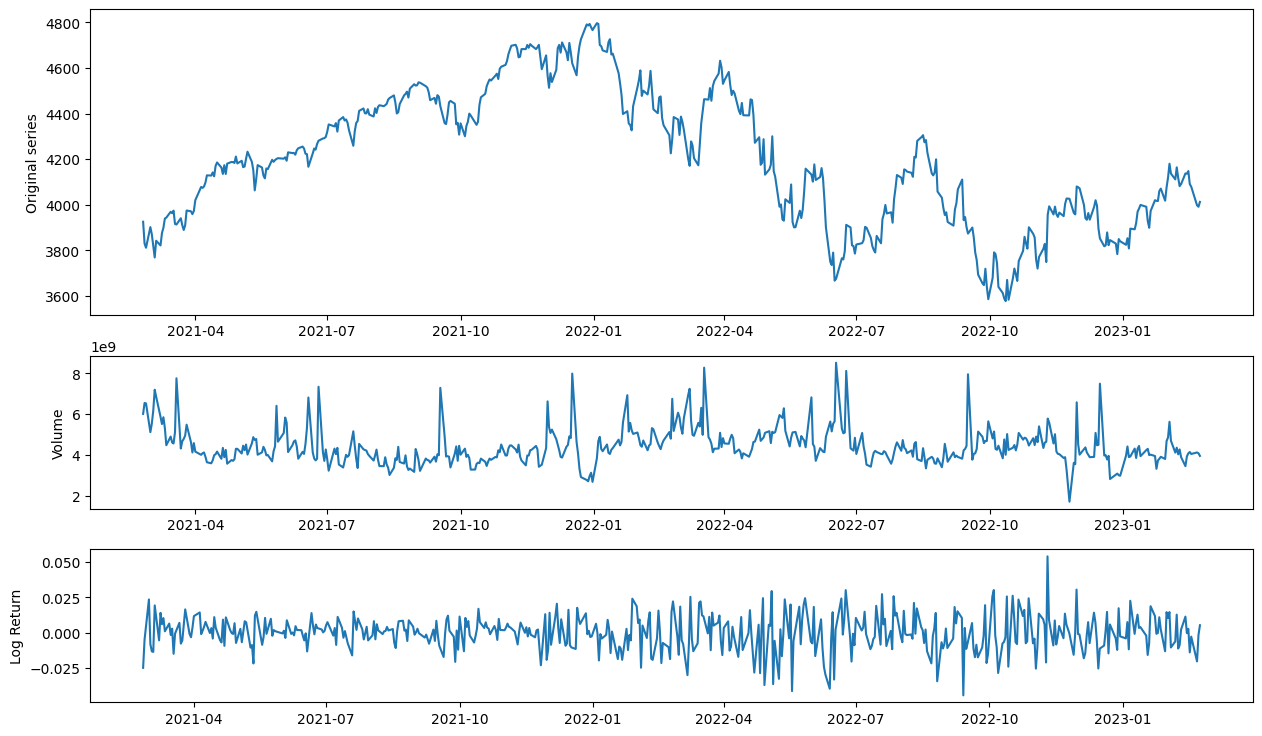

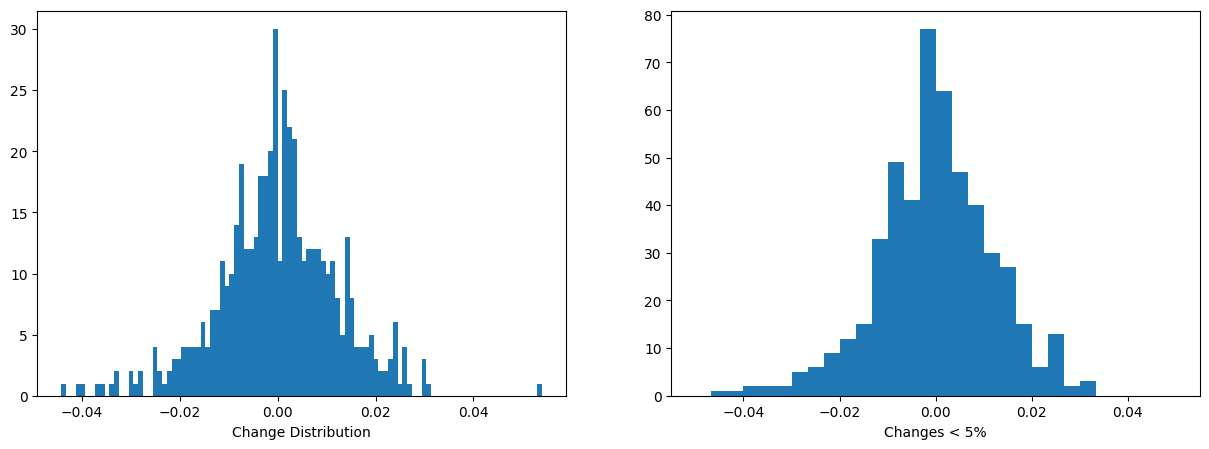

In [ ]:
view_data(base_data)

In [ ]:
def analysis(data: pd.DataFrame, *, shapiro_col = 'Adj Close', acf_plot_col = 'Adj Close' ,adf_col = "Adj Close"):

    res = pd.DataFrame(index = ['Base Series', 'Log Return'])
    print('Testing the distribution using Shapiro-Wilk Test.')
    print('==============')
    data.dropna(inplace=True)
    alpha = 0.5

    res['follows Gaussian?'] = [ shapiro(base_data[shapiro_col])[1]> 0.5 for shapiro_col in ['Adj Close', 'Return']]
    # print("\tTime Series "+ ("follows" if p> alpha else "doesn't follow") +" Gaussian distribution")
    if shapiro(data["Adj Close"])[1]> alpha:
        print("\tTime Series follows Gaussian distribution")
    else:
        print("\tTime Series doesn't follow Gaussian distribution")

    if shapiro(data["Return"])[1]> alpha:
        print("\Return follows Gaussian distribution")
    else:
        print("\tReturn doesn't follow Gaussian distribution")

    # 3. Performing the ADF Test for stationarity

    res['Stationary?'] = [adfuller(base_data[col])[0] < adfuller(base_data[col])[4]['5%']  for col in ['Adj Close', 'Return']]

    print('ADF Test Results:')
    print('==============')
    for c in ['Adj Close', 'Return']:
        adf_test = adfuller(data[c], autolag='AIC')
        print(f'Log Return:\t {"Stationary" if adf_test[0] < adf_test[4]["5%"] else "Non-stationary"}\tTest Statistic:', adf_test[0], '\tp-value:', adf_test[1], '\tCritical Values:', adf_test[4])
    # 2. Plotting Autocorrelation
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    plot_acf(data['Adj Close'], lags=20, ax=ax[0])
    ax[0].set_title("Original Series")
    plot_acf(data['Return'], lags=20, ax=ax[1])
    ax[1].set_title("Return")

    plt.show()

    return res

Testing the distribution using Shapiro-Wilk Test.
	Time Series doesn't follow Gaussian distribution
	Return doesn't follow Gaussian distribution
ADF Test Results:
Log Return:	 Non-stationary	Test Statistic: -2.100023728981886 	p-value: 0.2445050600657614 	Critical Values: {'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}
Log Return:	 Stationary	Test Statistic: -22.469794954776344 	p-value: 0.0 	Critical Values: {'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


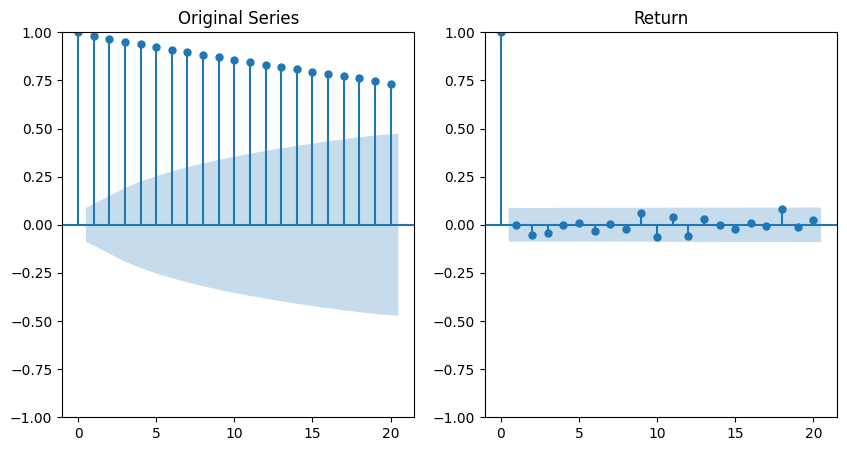

,follows Gaussian?,Stationary?
Base Series,False,False
Log Return,False,True


In [ ]:
analysis(base_data)

# 1.2 Performing Historical Volatility on the Dataset

In [ ]:
window_size = 20
base_data['Variance'] = [base_data['Return'][i-window_size+1:i+1].var() for i in range(len(base_data))]
base_data['Volatility'] = np.sqrt(base_data['Variance'])

In [ ]:
base_data.head()

,Adj Close,Volume,Return,Variance,Volatility
Date,,,,,
2021-02-25,3829.340088,6547470000,-0.024783,NaN,NaN
2021-02-26,3811.149902,6526070000,-0.004762,NaN,NaN
2021-03-01,3901.820068,5114820000,0.023512,NaN,NaN
2021-03-02,3870.290039,5536010000,-0.008114,NaN,NaN
2021-03-03,3819.719971,6173660000,-0.013152,NaN,NaN


In [ ]:
base_data.dropna(inplace=True)

In [ ]:
base_data.reset_index(inplace=True)

# 2.0 Fitting the Model

In [ ]:

mod_kns = sm.tsa.MarkovRegression(base_data['Volatility'], k_regimes=2, trend='n', switching_variance=True)
res_kns = mod_kns.fit()
print(res_kns.summary())

                        Markov Switching Model Results                        
Dep. Variable:             Volatility   No. Observations:                  484
Model:               MarkovRegression   Log Likelihood                1438.165
Date:                Sun, 14 Jan 2024   AIC                          -2868.329
Time:                        12:01:26   BIC                          -2851.601
Sample:                             0   HQIC                         -2861.756
                                - 484                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.31e-05      6.649      0.000       0.000       0.000
                             Regime 1 parameters    

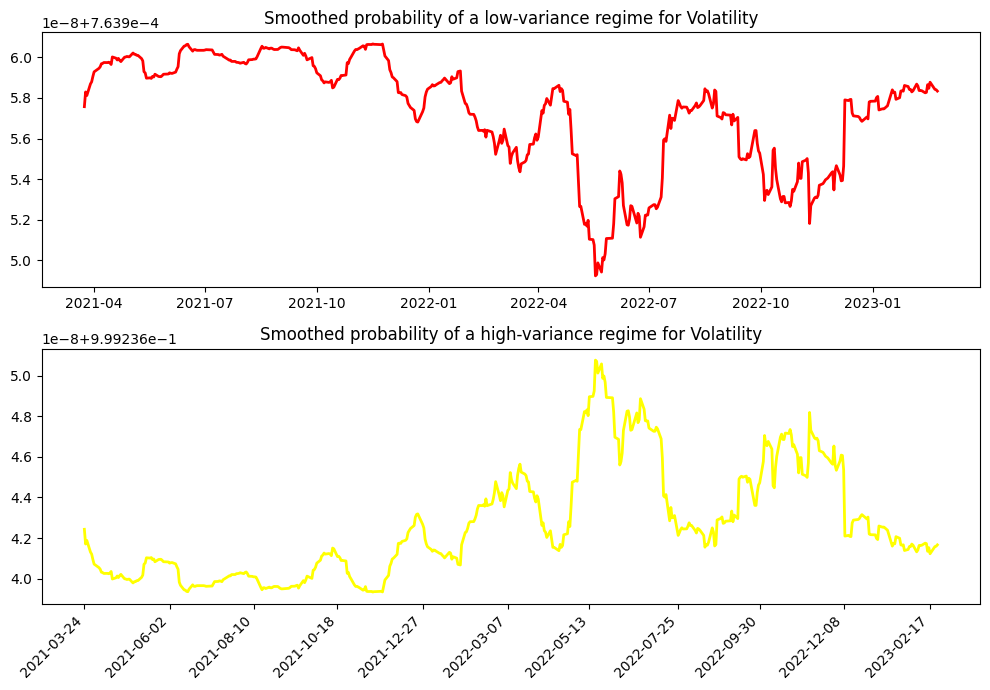

In [ ]:
dates = base_data['Date']

# Plotting the smoothed probabilities of the regimes with adjusted parameters
fig, axes = plt.subplots(2, figsize=(10, 7))

# Plot for the low-variance regime
ax = axes[0]
ax.plot(dates, res_kns.smoothed_marginal_probabilities[0], linewidth=2, linestyle='-', color='red')
ax.set(title='Smoothed probability of a low-variance regime for Volatility')

# Plot for the high-variance regime
ax = axes[1]
ax.plot(dates, res_kns.smoothed_marginal_probabilities[1], linewidth=2, linestyle='-', color='yellow')
ax.set(title='Smoothed probability of a high-variance regime for Volatility')

# Set x-axis ticks &labels
ax.set_xticks(dates[::len(dates)//10])
ax.set_xticklabels(dates.dt.strftime('%Y-%m-%d').values[::len(dates)//10], rotation=45, ha='right')
fig.tight_layout()
plt.show()

##Low Variance Regime:
During periods of low variance, the ^SPX financial time series exhibit relatively stable and less volatile behavior. This regime corresponds to periods of calm or low uncertainty in the market.

##High Variance Regime:
High variance regimes corresponds to periods of heightened volatility and increased variability in the time series. This regime might correspond to turbulent market conditions, high uncertainty, or periods of increased risk.

In [ ]:
low_var = list(res_kns.smoothed_marginal_probabilities[0])
high_var = list(res_kns.smoothed_marginal_probabilities[1])

# Calculate mean and std dev of volatilities
mean_volatility = np.mean(low_var)
std_volatility = np.std(low_var)

# Setting threshold as mean + k * std
k = 0.1
threshold = mean_volatility + k * std_volatility

# Assign regimes based on the threshold
regime_list = [0 if vol < threshold else 1 for vol in low_var]

In [ ]:
regime_list = []
for i in range(len(low_var)):
    if low_var[i] < threshold:
        regime_list.append(0)
    else:
        regime_list.append(1)

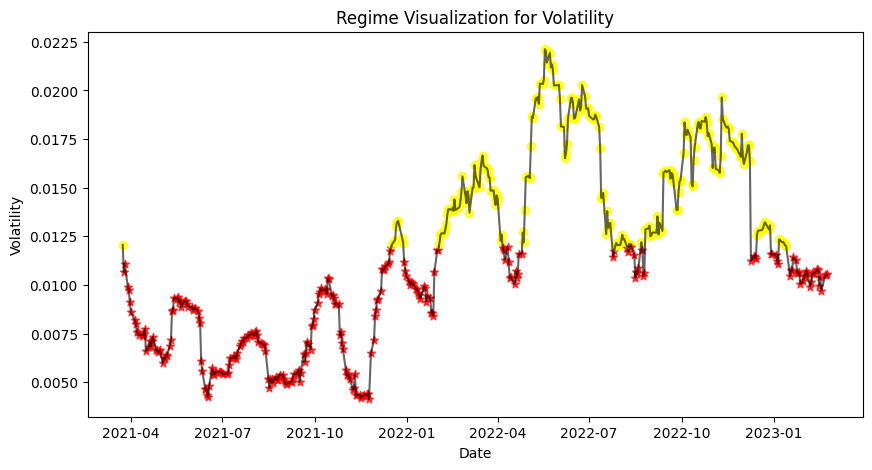

In [ ]:
# Visualize regimes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the volatility data
ax.plot(base_data['Date'], base_data['Volatility'], color='black', alpha=0.6)

# Highlight regimes with different colors
for i, regime in enumerate(regime_list):
    if regime == 0:
        ax.scatter(base_data['Date'].iloc[i], base_data['Volatility'].iloc[i], color='yellow', marker='o', alpha=0.7)
    else:
        ax.scatter(base_data['Date'].iloc[i], base_data['Volatility'].iloc[i], color='red', marker='*', alpha=0.7)


ax.set(xlabel='Date', ylabel='Volatility', title='Regime Visualization for Volatility')
plt.show()

In [ ]:
ml_df = base_data.copy()

# Price and volume returns
for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)

ml_df.dropna(inplace=True)

# Probabilities
low_var_prob = list(res_kns.smoothed_marginal_probabilities[0])
high_var_prob = list(res_kns.smoothed_marginal_probabilities[1])
ml_df['Low_Var_Prob'] = low_var_prob[-len(ml_df):]  # Adjust length
ml_df['High_Var_Prob'] = high_var_prob[-len(ml_df):]  # Adjust length

# Volatility
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()

ml_df.dropna(inplace=True)

# States
ml_df['regimes'] = regime_list[-len(ml_df):]  # Adjust length

ml_df.head()

,Date,Adj Close,Volume,Return,Variance,Volatility,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
41,2021-05-21,4155.859863,3995250000,-0.000784,0.000079,0.008867,-0.000784,0.004114,0.009763,-0.059377,...,-0.018419,0.005050,-0.058865,0.000764,0.999236,0.007221,0.009055,0.010306,0.008979,1
42,2021-05-24,4197.049805,3684800000,0.009862,0.000084,0.009146,0.009911,-0.077705,0.009120,-0.073910,...,-0.172413,0.004038,0.032192,0.000764,0.999236,0.006339,0.008723,0.010504,0.008922,1
43,2021-05-25,4188.129883,4182250000,-0.002128,0.000084,0.009159,-0.002125,0.135001,0.007765,0.046806,...,-0.011503,0.000122,0.115767,0.000764,0.999236,0.006569,0.007062,0.010529,0.008928,1
44,2021-05-26,4195.990234,4420890000,0.001875,0.000084,0.009166,0.001877,0.057060,-0.000252,0.199764,...,-0.019976,0.002214,0.191390,0.000764,0.999236,0.006104,0.006944,0.010303,0.008937,1
45,2021-05-27,4200.879883,6406310000,0.001165,0.000082,0.009039,0.001165,0.449100,0.003044,0.531786,...,0.595165,0.004231,0.691498,0.000764,0.999236,0.002136,0.005511,0.010090,0.008937,1


In [ ]:
ml_df['regimes'] = ml_df['regimes'].shift(-1)
ml_df.dropna(inplace=True)
ml_df

,Date,Adj Close,Volume,Return,Variance,Volatility,Close_1_Value,Volume_1_Value,Close_2_Value,Volume_2_Value,...,Volume_14_Value,Close_21_Value,Volume_21_Value,Low_Var_Prob,High_Var_Prob,Volt_3_Value,Volt_7_Value,Volt_14_Value,Volt_21_Value,regimes
41,2021-05-21,4155.859863,3995250000,-0.000784,0.000079,0.008867,-0.000784,0.004114,0.009763,-0.059377,...,-0.018419,0.005050,-0.058865,0.000764,0.999236,0.007221,0.009055,0.010306,0.008979,1.0
42,2021-05-24,4197.049805,3684800000,0.009862,0.000084,0.009146,0.009911,-0.077705,0.009120,-0.073910,...,-0.172413,0.004038,0.032192,0.000764,0.999236,0.006339,0.008723,0.010504,0.008922,1.0
43,2021-05-25,4188.129883,4182250000,-0.002128,0.000084,0.009159,-0.002125,0.135001,0.007765,0.046806,...,-0.011503,0.000122,0.115767,0.000764,0.999236,0.006569,0.007062,0.010529,0.008928,1.0
44,2021-05-26,4195.990234,4420890000,0.001875,0.000084,0.009166,0.001877,0.057060,-0.000252,0.199764,...,-0.019976,0.002214,0.191390,0.000764,0.999236,0.006104,0.006944,0.010303,0.008937,1.0
45,2021-05-27,4200.879883,6406310000,0.001165,0.000082,0.009039,0.001165,0.449100,0.003044,0.531786,...,0.595165,0.004231,0.691498,0.000764,0.999236,0.002136,0.005511,0.010090,0.008937,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,2023-02-15,4147.600098,4075980000,0.002769,0.000099,0.009966,0.002773,0.037356,0.002492,0.181916,...,0.069926,0.039246,-0.037676,0.000764,0.999236,0.006049,0.009105,0.010121,0.010510,1.0
479,2023-02-16,4090.409912,4143660000,-0.013885,0.000108,0.010394,-0.013789,0.016605,-0.011054,0.054581,...,0.060367,0.041119,-0.036069,0.000764,0.999236,0.008867,0.009058,0.010915,0.010366,1.0
480,2023-02-17,4079.090088,4045480000,-0.002771,0.000094,0.009704,-0.002767,-0.023694,-0.016518,-0.007483,...,0.064040,0.046229,0.013524,0.000764,0.999236,0.008481,0.008251,0.010270,0.010194,1.0
481,2023-02-21,3997.340088,4121590000,-0.020245,0.000110,0.010495,-0.020041,0.018814,-0.022753,-0.005326,...,-0.119190,0.006225,0.026967,0.000764,0.999236,0.008844,0.010727,0.010950,0.010565,1.0


## 2.1 Plotting the Markov Regression Data Against VIX Data

In [ ]:
# Create a copy of ml_df so as not to accidentally overwrite the original copy
ml_df_copy = ml_df.copy()

In [ ]:
# Merge ml_df_copy with vix_data based on date
ml_df_copy = pd.merge(ml_df_copy, vix_data, on='Date', how='left')

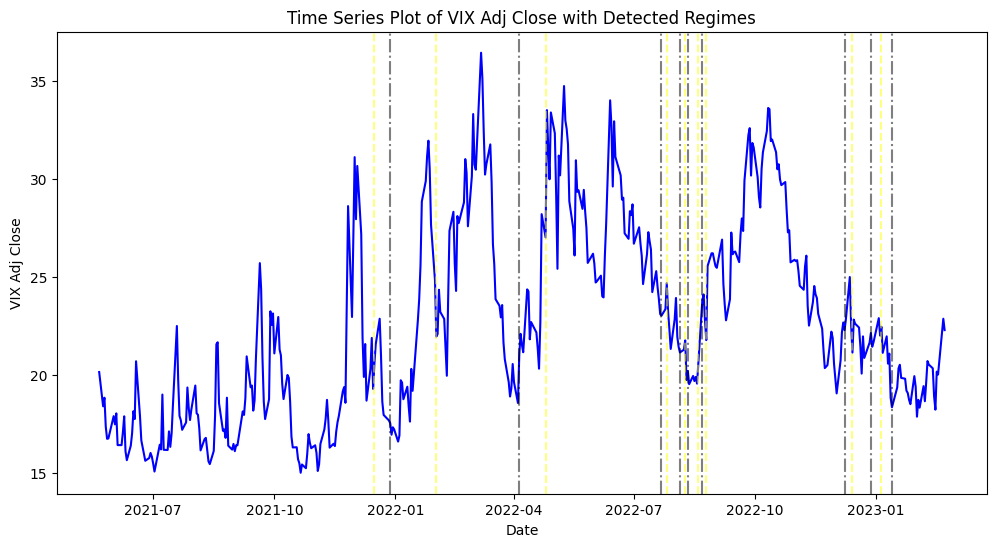

In [ ]:
# Creating a time series plot
plt.figure(figsize=(12, 6))
plt.plot(ml_df_copy['Date'], ml_df_copy['Adj Close_y'], label='VIX Adj Close', color='blue')

# Adding vertical dashed lines to indicate section of regime changes
for i, regime in enumerate(ml_df_copy['regimes'].diff().fillna(0)):
    if regime != 0:
        linestyle = '--' if regime == -1 else '-.'
        linecolor = 'yellow' if linestyle == '--' else 'black'  # Set yellow color for '--' and black color for '-.'
        plt.axvline(ml_df_copy['Date'].iloc[i], color=linecolor, linestyle=linestyle, label='Regime Change', alpha=0.5)

plt.title('Time Series Plot of VIX Adj Close with Detected Regimes')
plt.xlabel('Date')
plt.ylabel('VIX Adj Close')
plt.show()

In [ ]:
# Performing a Correlation Analysis
correlation, _ = kendalltau(ml_df_copy['regimes'], ml_df_copy['Adj Close_y'])
print(f"Kendall's Tau Correlation: {correlation}")

Kendall's Tau Correlation: -0.5555370502943956


The high negative correlation suggests that there is a consistent pattern where the detected regimes and VIX Adj Close move in opposite directions.

In [ ]:
# Align the regimes and Adj Close_y
aligned_data = pd.merge(ml_df_copy[['Date', 'regimes']], ml_df_copy[['Date', 'Adj Close_y']], on='Date', how='inner')

# Calculate cross-correlation
cross_corr = np.correlate(aligned_data['regimes'], aligned_data['Adj Close_y'], mode='full')

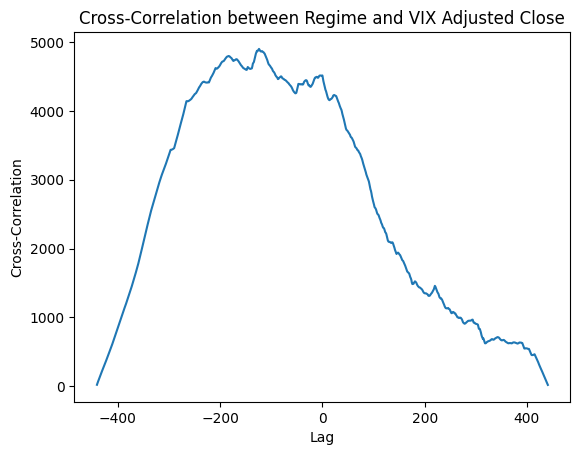

In [ ]:
lags = np.arange(-len(aligned_data) + 1, len(aligned_data))
plt.plot(lags, cross_corr)
plt.title('Cross-Correlation between Regime and VIX Adjusted Close')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.show()

A peak in the negative lag suggest that the detected regime would precede the VIX data.

<Figure size 1200x600 with 0 Axes>

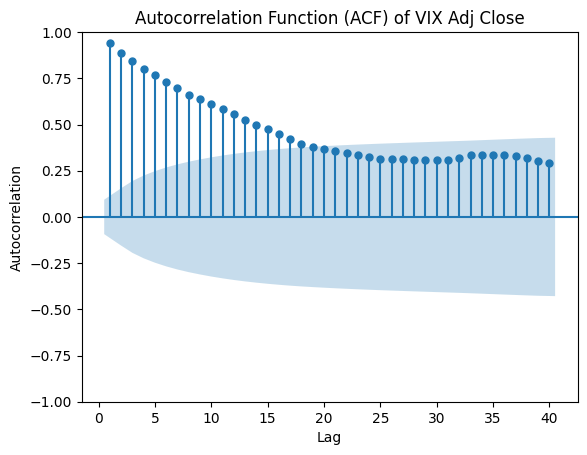

<Figure size 1200x600 with 0 Axes>

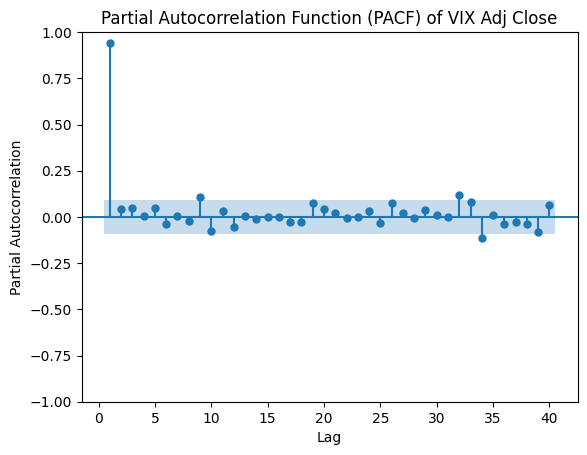

In [ ]:
# ACF and PACF Test
plt.figure(figsize=(12, 6))
plot_acf(ml_df_copy['Adj Close_y'], lags=40, zero=False)
plt.title('Autocorrelation Function (ACF) of VIX Adj Close')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(ml_df_copy['Adj Close_y'], lags=40, zero=False)
plt.title('Partial Autocorrelation Function (PACF) of VIX Adj Close')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

In [ ]:
# Statistical Tests for Regime Differences
low_regime_vix = ml_df_copy[ml_df_copy['regimes'] == 0]['Adj Close_y']
high_regime_vix = ml_df_copy[ml_df_copy['regimes'] == 1]['Adj Close_y']

_, p_value = ztest(low_regime_vix, high_regime_vix)
print(f"P-value for Mean Difference: {p_value}")

P-value for Mean Difference: 8.702209234281354e-74


The small p-value indicates strong evidence against the null hypothesis. The extremely small p-value suggests that the observed difference in means is not likely due to random chance alone. There is substantial evidence to support the conclusion that the mean values of VIX Adj Close are different during low and high regimes.

# 2.2 Fitting the data into HMSM Model
Constructing the training, validation and testing datasets.
Specifiying the d-date to be 24/2/2022 in order to create a point in time that divides the dataset into periods before and after the invasion date allowing us to train the model on pre-event data and assess its performance on post-event data.

A window period of 45 days are created, because the impact of the invasion is expected to be instantaneous, this is also to define the validation set.

In [ ]:
ml_df['Date'] = pd.to_datetime(ml_df['Date'])

# Invasion date known as d_date
d_date = datetime(2022, 2, 22)

# Defining window period
window_days = 45

# Create training set before d_date
train_set = ml_df[ml_df['Date'] < d_date]

# Create testing set after d_date
test_set = ml_df[ml_df['Date'] >= d_date]

# Create validation set
validation_start = d_date - timedelta(days=window_days)
validation_end = d_date + timedelta(days=window_days)
validation_set = ml_df[(ml_df['Date'] >= validation_start) & (ml_df['Date'] <= validation_end)]

# Printing out the shapes of the sets
print("Training Set Shape:", train_set.shape)
print("Validation Set Shape:", validation_set.shape)
print("Testing Set Shape:", test_set.shape)
print("Distribution of 'regimes' in Testing Set:")
print(test_set['regimes'].value_counts())

Training Set Shape: (190, 27)
Validation Set Shape: (63, 27)
Testing Set Shape: (252, 27)
Distribution of 'regimes' in Testing Set:
0.0    190
1.0     62
Name: regimes, dtype: int64


In [ ]:
# Extract features and labels from each set
X_train, y_train = train_set.drop(columns=['regimes']), train_set['regimes']
X_val, y_val = validation_set.drop(columns=['regimes']), validation_set['regimes']
X_test, y_test = test_set.drop(columns=['regimes']), test_set['regimes']

In [ ]:
# Adding 'Timestamp' column to X_train and X_test
X_train['Timestamp'] = X_train['Date'].apply(lambda x: x.timestamp())
X_train = X_train.drop(columns=['Date'])

X_test['Timestamp'] = X_test['Date'].apply(lambda x: x.timestamp())
X_test = X_test.drop(columns=['Date'])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'states_train'}>,
        <Axes: title={'center': 'states_train'}>],
       [<Axes: title={'center': 'mu_low'}>,
        <Axes: title={'center': 'mu_low'}>],
       [<Axes: title={'center': 'mu_high'}>,
        <Axes: title={'center': 'mu_high'}>],
       [<Axes: title={'center': 'p_low_to_low'}>,
        <Axes: title={'center': 'p_low_to_low'}>],
       [<Axes: title={'center': 'p_high_to_high'}>,
        <Axes: title={'center': 'p_high_to_high'}>],
       [<Axes: title={'center': 'p_init'}>,
        <Axes: title={'center': 'p_init'}>],
       [<Axes: title={'center': 'sigma_low'}>,
        <Axes: title={'center': 'sigma_low'}>],
       [<Axes: title={'center': 'sigma_high'}>,
        <Axes: title={'center': 'sigma_high'}>]], dtype=object)

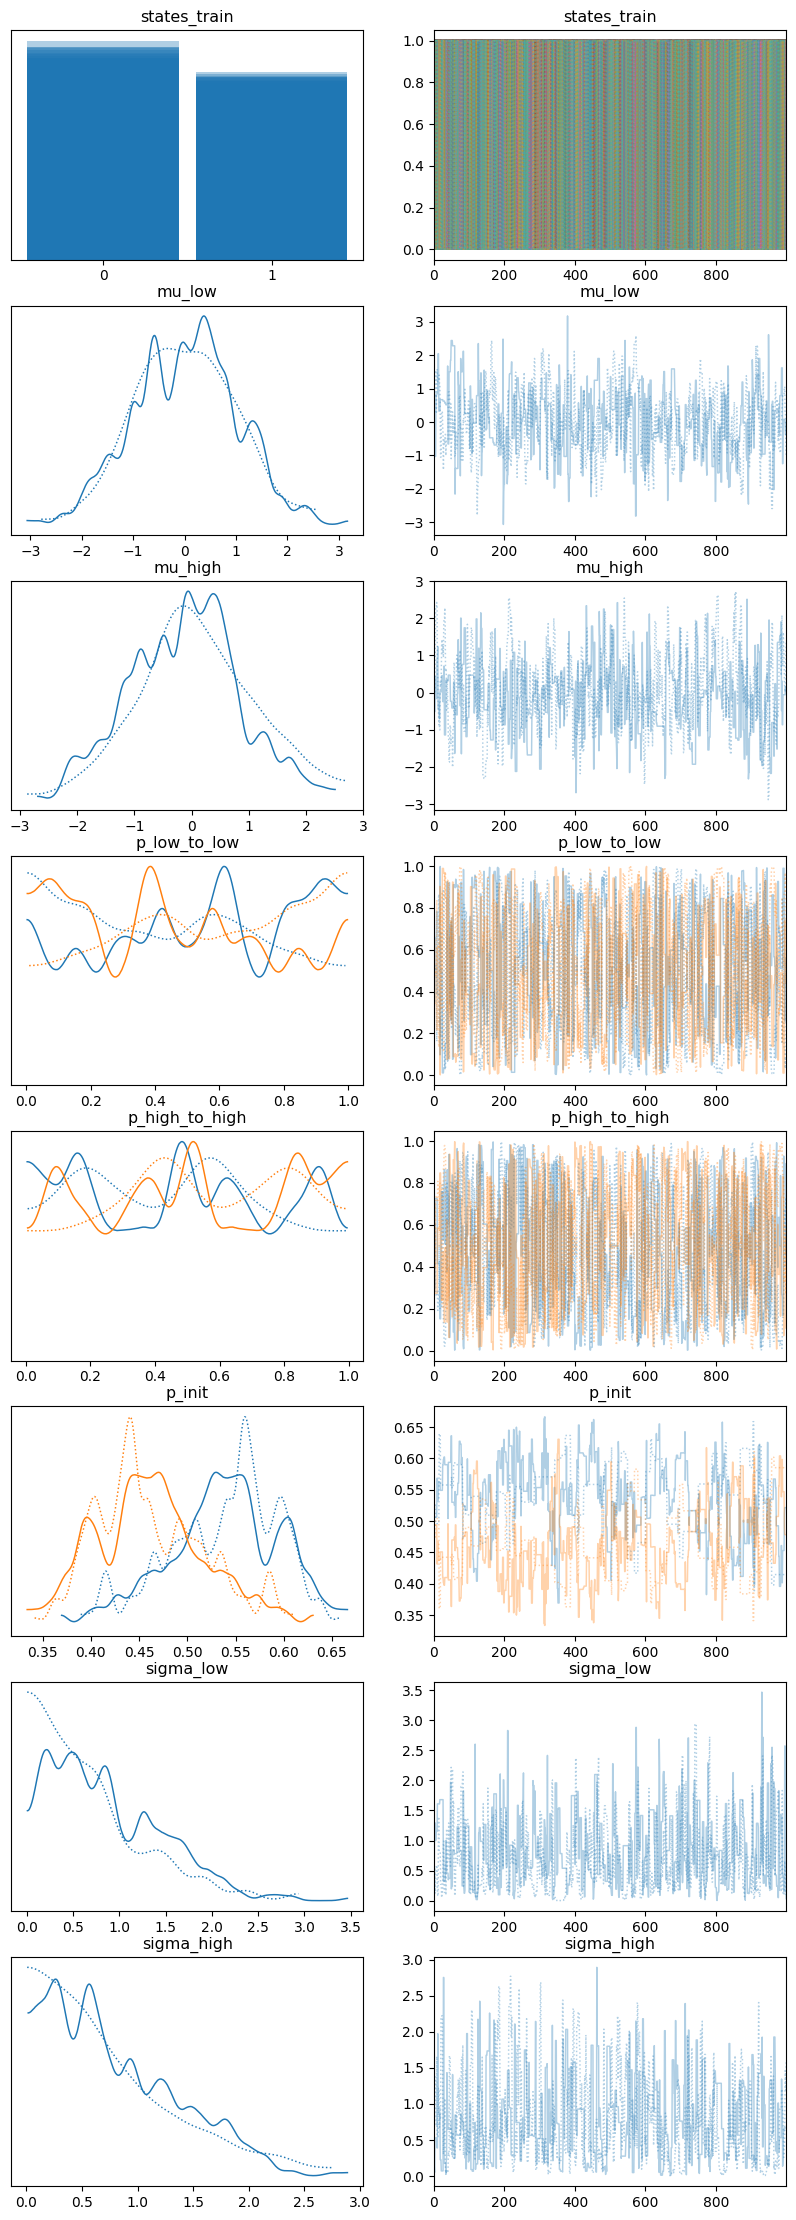

In [ ]:
# Setting a random seed for consistent outcome of each run otherwise each run the results would be different
np.random.seed(42)

# Defining the HMSM model
with pm.Model() as model_hmsm:
    # Define transition probabilities using Dirichlet Distribution
    p_low_to_low = pm.Dirichlet('p_low_to_low', a=np.ones(2))
    p_high_to_high = pm.Dirichlet('p_high_to_high', a=np.ones(2))

    # Define initial state probabilities
    p_init = pm.Dirichlet('p_init', a=np.ones(2))

    # Reshape states_train to obtain the right dimensions
    states_train = pm.Categorical('states_train', p=p_init, shape=(len(X_train),))

    # Define separate distributions for each state
    mu_low = pm.Normal('mu_low', mu=0, sigma=1)
    sigma_low = pm.HalfNormal('sigma_low', sigma=1)

    mu_high = pm.Normal('mu_high', mu=0, sigma=1)
    sigma_high = pm.HalfNormal('sigma_high', sigma=1)

    # Create a masked array
    obs_low_train_values = np.ma.masked_array(X_train['Volatility'].values, mask=(states_train != 0))
    obs_high_train_values = np.ma.masked_array(X_train['Volatility'].values, mask=(states_train != 1))

    obs_low_train = pm.Normal('obs_low_train', mu=mu_low, sigma=sigma_low, observed=obs_low_train_values)
    obs_high_train = pm.Normal('obs_high_train', mu=mu_high, sigma=sigma_high, observed=obs_high_train_values)

    # Sample from the model
    trace_hmsm = pm.sample(1000, tune=13000, step=pm.Metropolis(), cores=1)

# Ploting the train set
pm.plot_trace(trace_hmsm, figsize=(10, 28))

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (200) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'states_train\n0'}>,
        <Axes: title={'center': 'states_train\n1'}>,
        <Axes: title={'center': 'states_train\n2'}>,
        <Axes: title={'center': 'states_train\n3'}>],
       [<Axes: title={'center': 'states_train\n4'}>,
        <Axes: title={'center': 'states_train\n5'}>,
        <Axes: title={'center': 'states_train\n6'}>,
        <Axes: title={'center': 'states_train\n7'}>],
       [<Axes: title={'center': 'states_train\n8'}>,
        <Axes: title={'center': 'states_train\n9'}>,
        <Axes: title={'center': 'states_train\n10'}>,
        <Axes: title={'center': 'states_train\n11'}>],
       [<Axes: title={'center': 'states_train\n12'}>,
        <Axes: title={'center': 'states_train\n13'}>,
        <Axes: title={'center': 'states_train\n14'}>,
        <Axes: title={'center': 'states_train\n15'}>],
       [<Axes: title={'center': 'states_train\n16'}>,
        <Axes: title={'center': 'states_train\n17'}>,
        <Axes: title={'center': 's

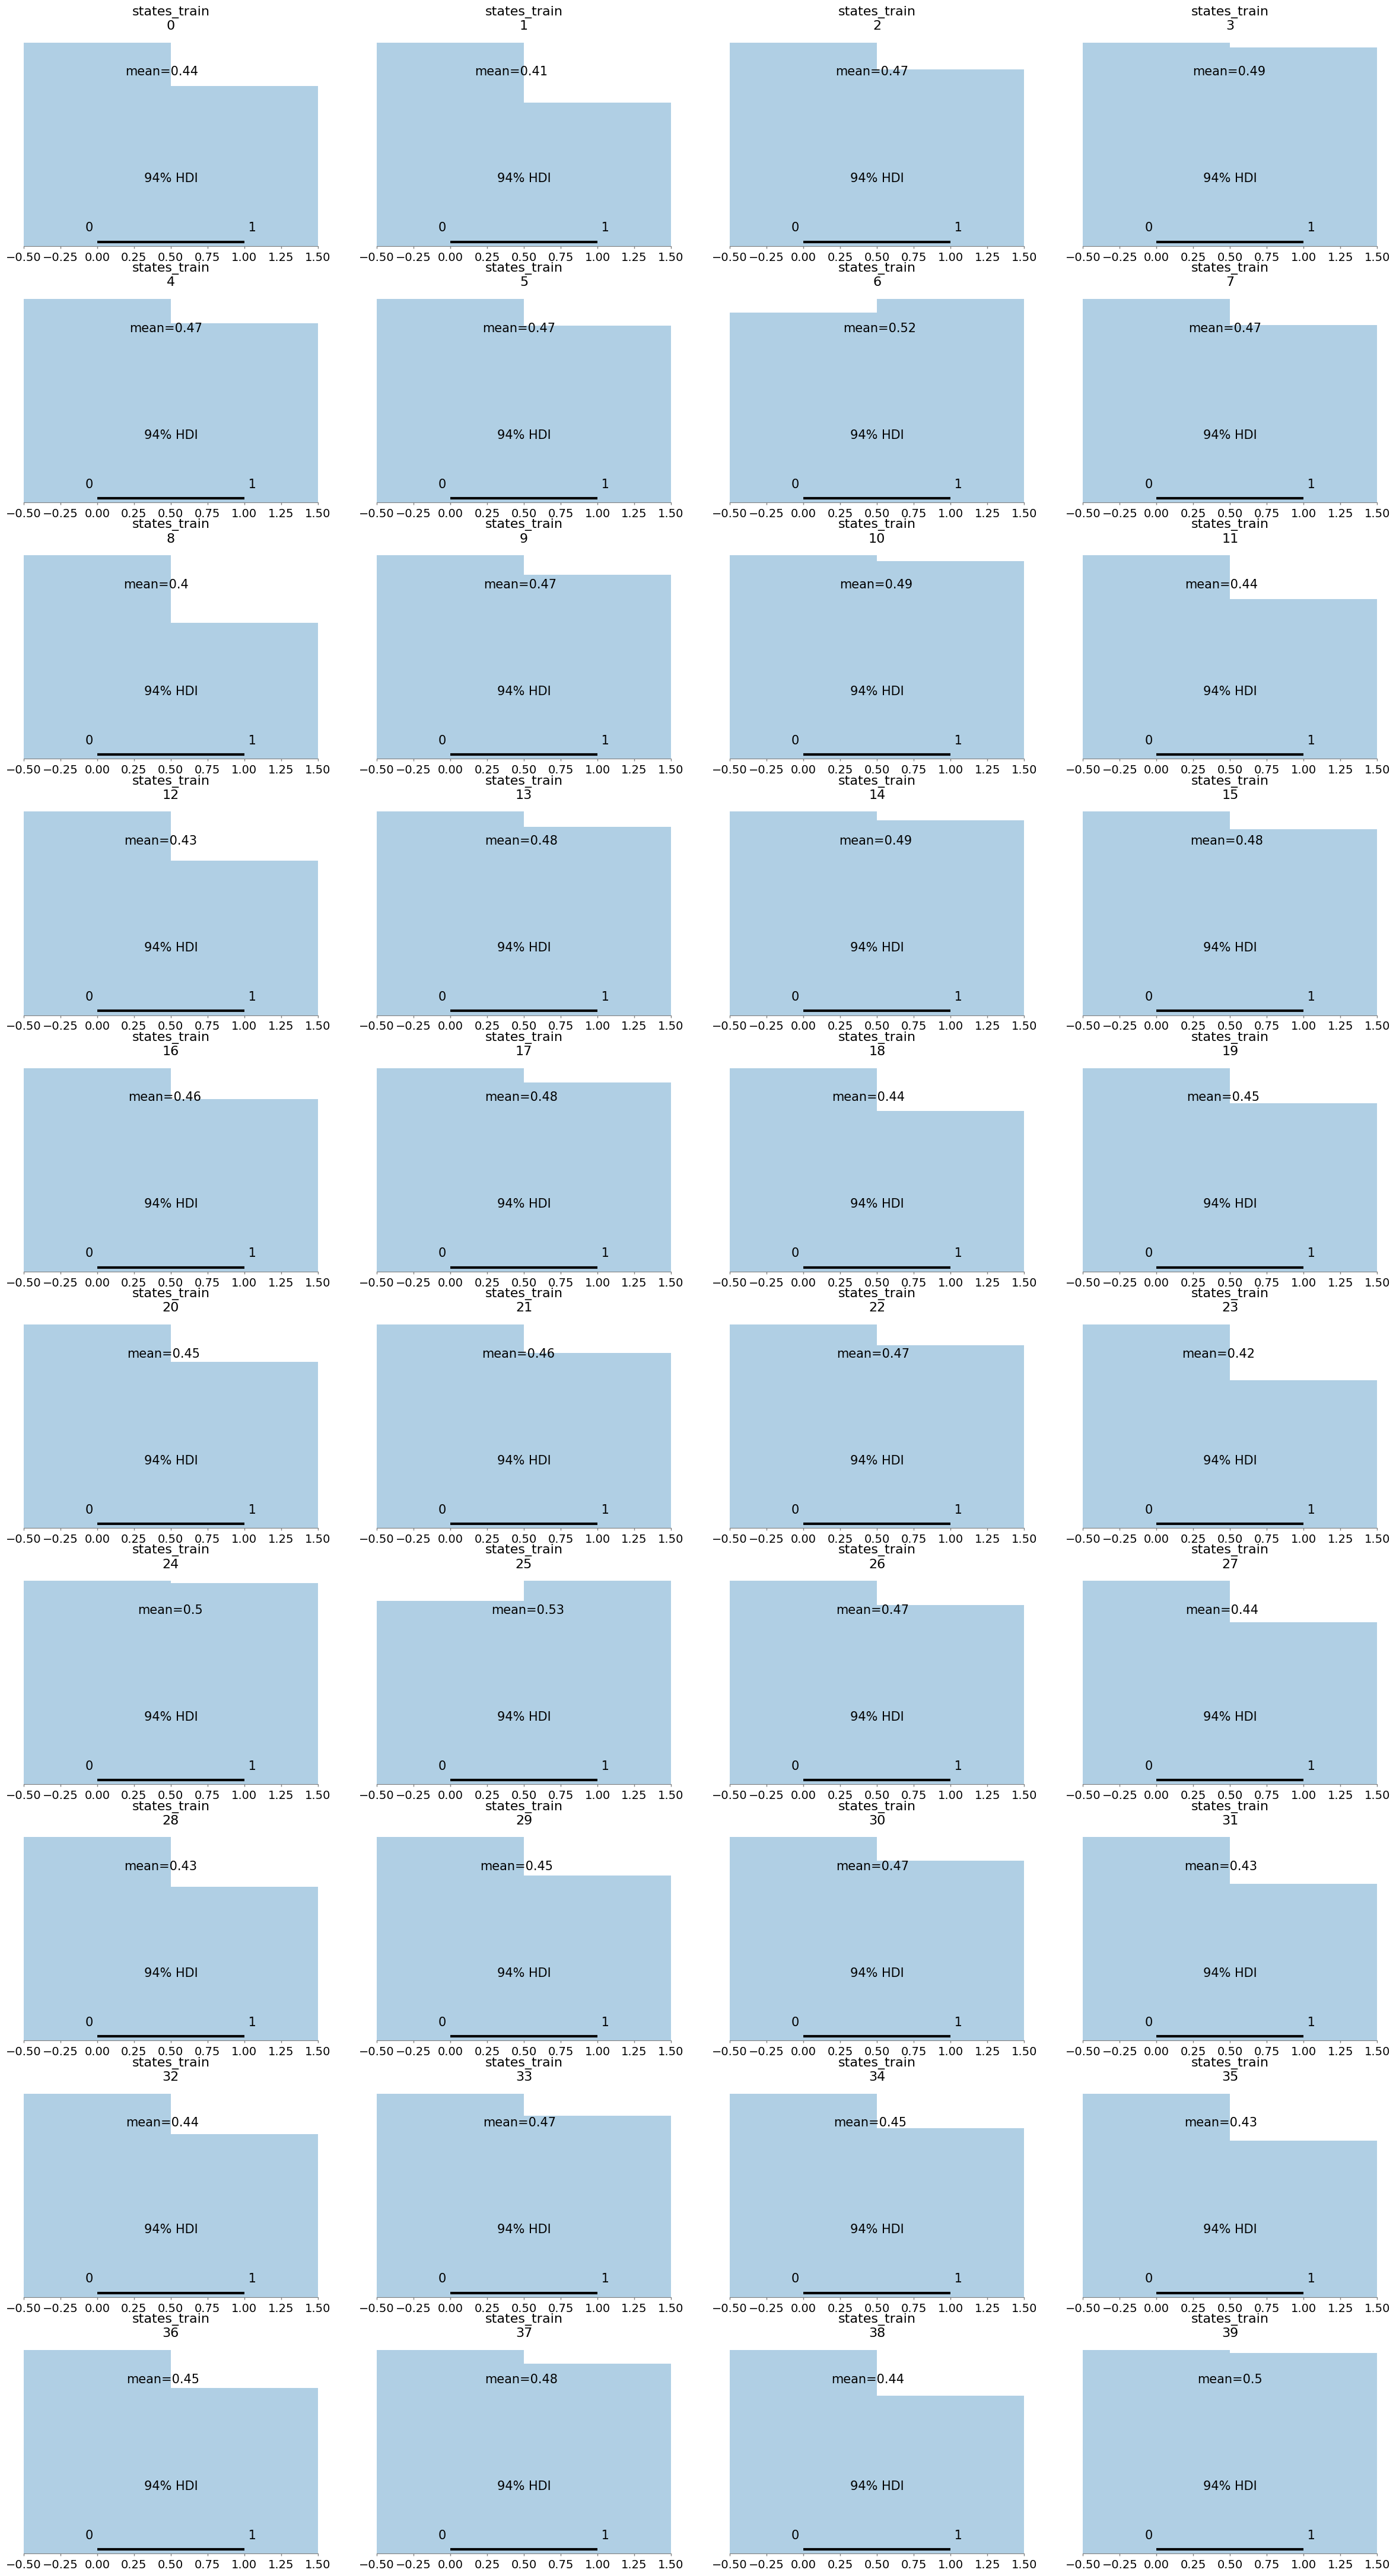

In [ ]:
#Plotting the Posterior Distributions

pm.plot_posterior(trace_hmsm)

A close proximate value of 94% HDI provides a balance between precision and confidence in the Bayesian analysis.

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (400) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'states_train\n0, 0'}>,
        <Axes: title={'center': 'states_train\n0, 1'}>,
        <Axes: title={'center': 'states_train\n0, 2'}>,
        <Axes: title={'center': 'states_train\n0, 3'}>],
       [<Axes: title={'center': 'states_train\n0, 4'}>,
        <Axes: title={'center': 'states_train\n0, 5'}>,
        <Axes: title={'center': 'states_train\n0, 6'}>,
        <Axes: title={'center': 'states_train\n0, 7'}>],
       [<Axes: title={'center': 'states_train\n0, 8'}>,
        <Axes: title={'center': 'states_train\n0, 9'}>,
        <Axes: title={'center': 'states_train\n0, 10'}>,
        <Axes: title={'center': 'states_train\n0, 11'}>],
       [<Axes: title={'center': 'states_train\n0, 12'}>,
        <Axes: title={'center': 'states_train\n0, 13'}>,
        <Axes: title={'center': 'states_train\n0, 14'}>,
        <Axes: title={'center': 'states_train\n0, 15'}>],
       [<Axes: title={'center': 'states_train\n0, 16'}>,
        <Axes: title={'center': 'stat

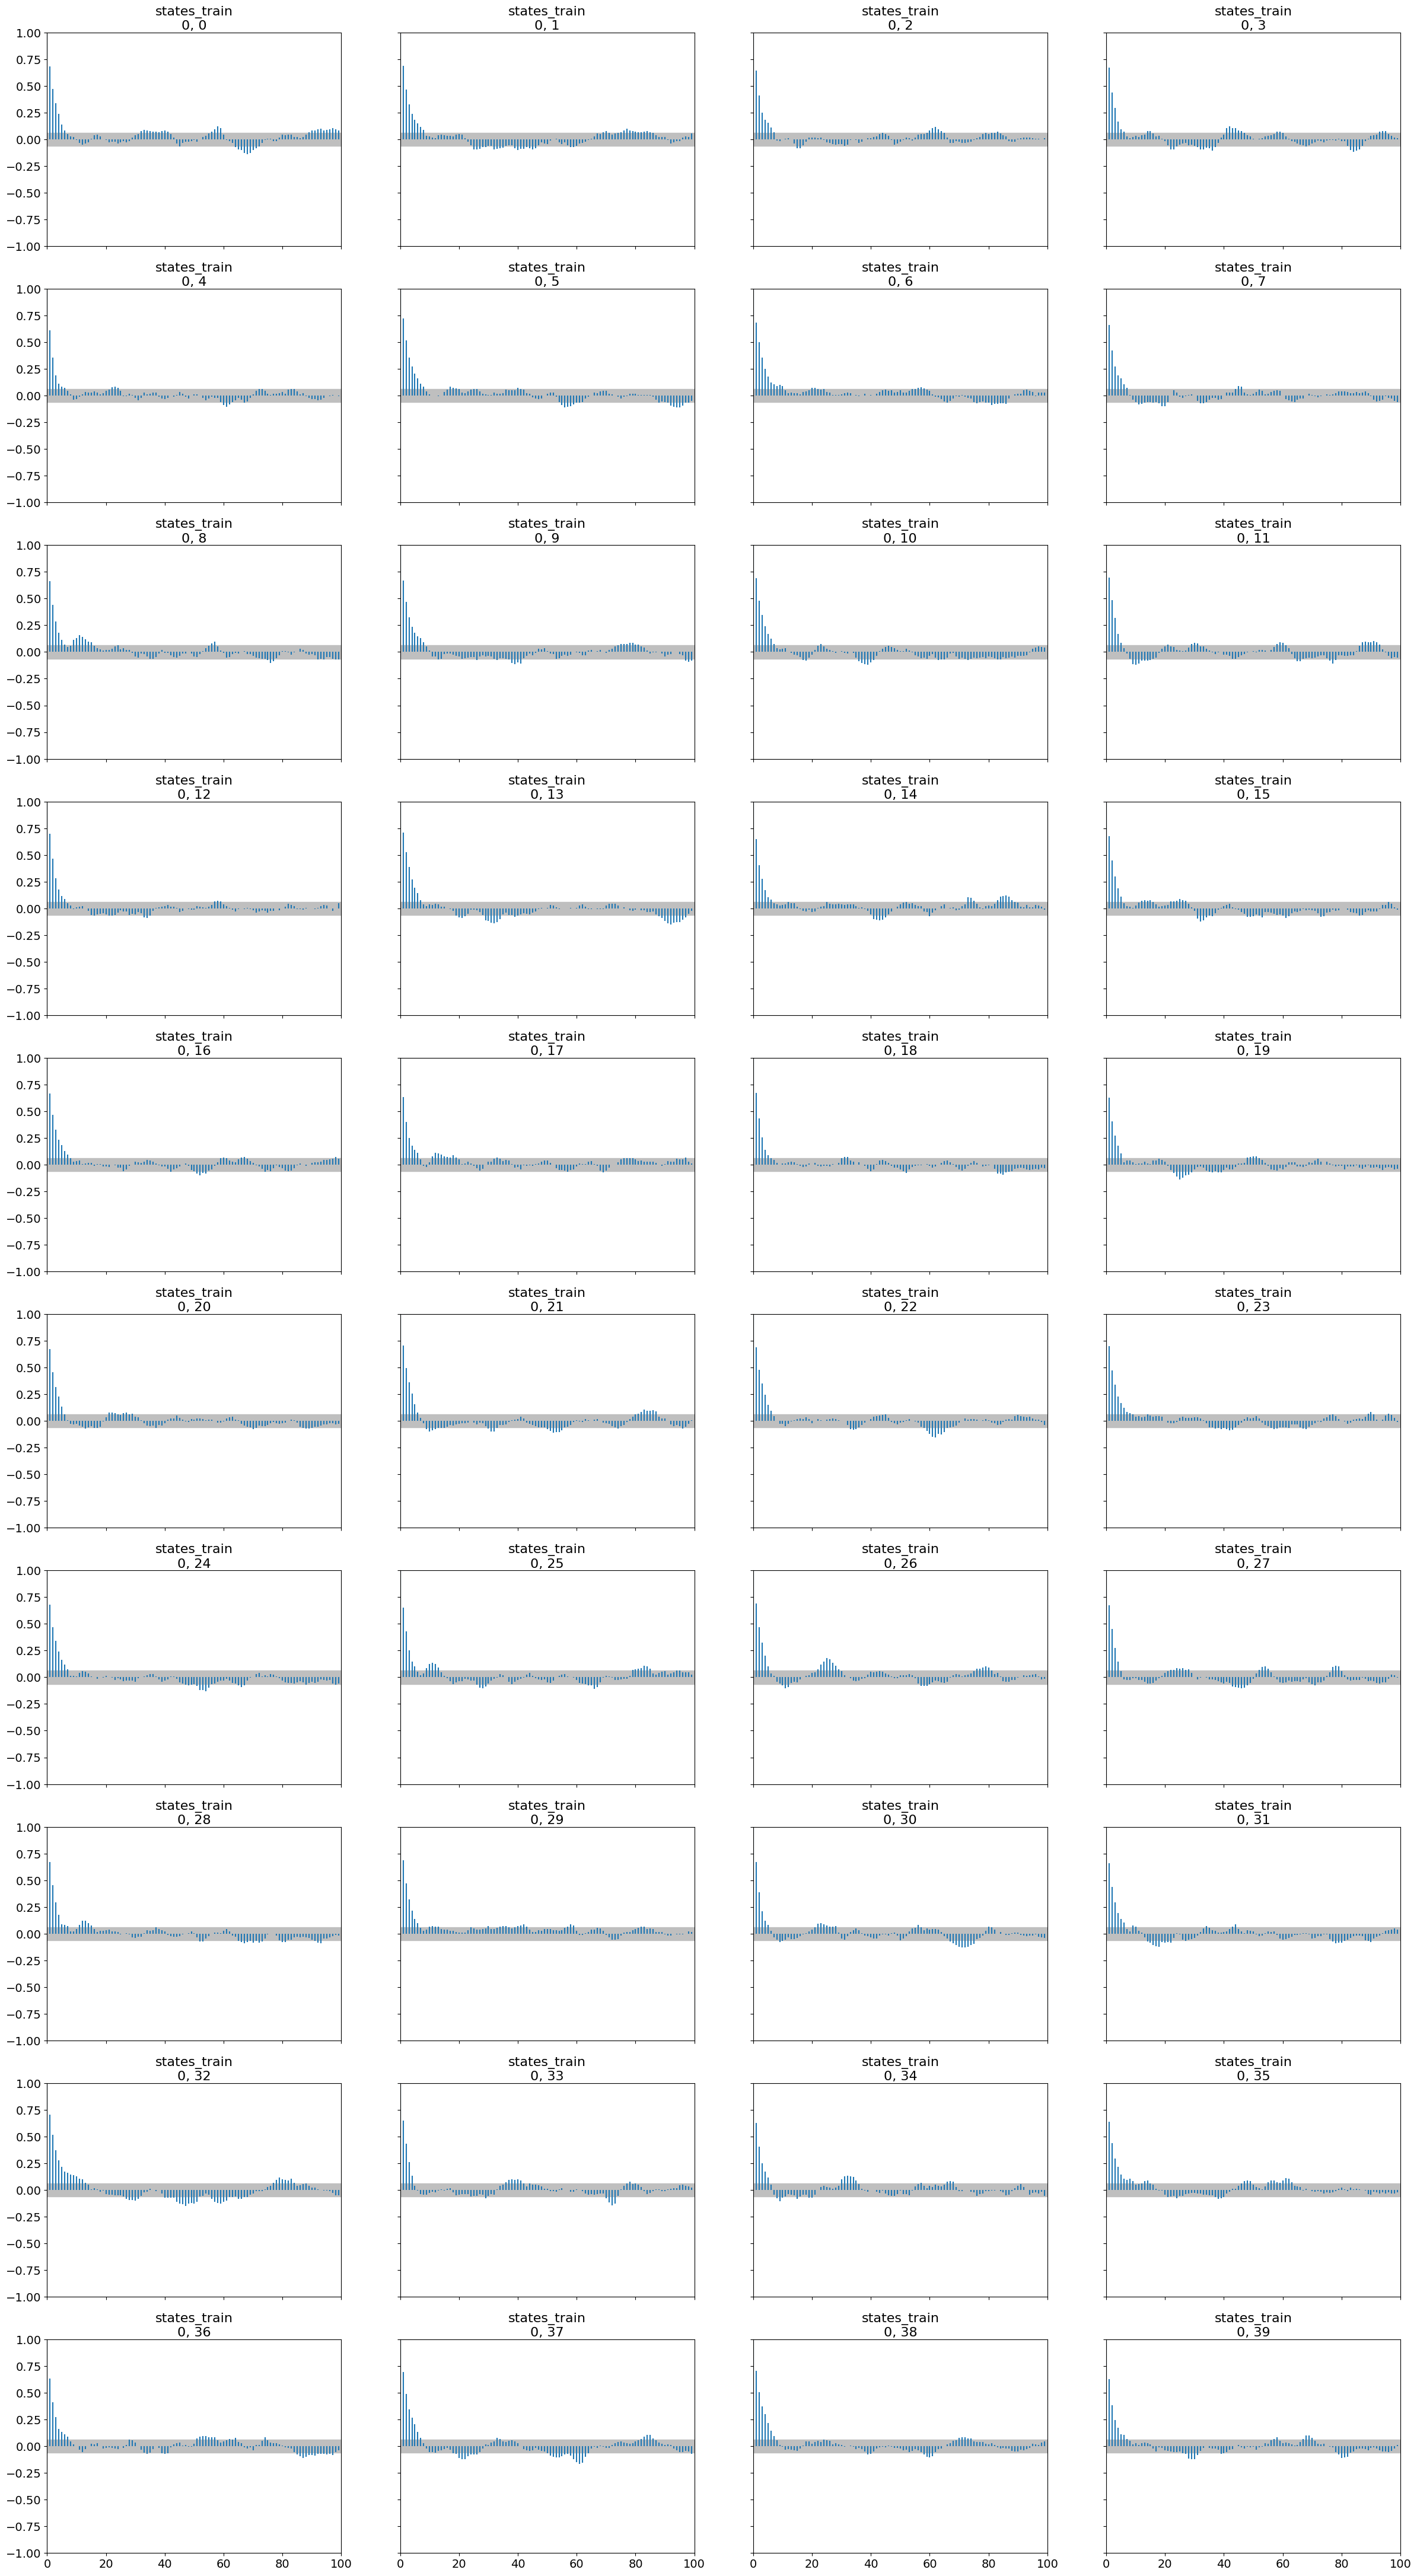

In [ ]:
# Examining the autocorrelation plots to assess how quickly the Markov Chain forgets previous samples
pm.plot_autocorr(trace_hmsm)

In [ ]:
# Summary of the train set

pm.summary(trace_hmsm).tail()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_high_to_high[1],0.517,0.283,0.074,0.984,0.015,0.011,345.0,350.0,1.01
p_init[0],0.538,0.057,0.412,0.622,0.007,0.005,73.0,83.0,1.03
p_init[1],0.462,0.057,0.378,0.588,0.007,0.005,73.0,79.0,1.03
sigma_low,0.778,0.594,0.001,1.866,0.031,0.022,242.0,161.0,1.02
sigma_high,0.776,0.591,0.004,1.845,0.030,0.021,310.0,276.0,1.01


In [ ]:
# Extract the mean values for initial state probabilities
p_init_mean = np.mean(trace_hmsm.posterior.p_init.values, axis=(0, 1))

# Convert p_init_mean
p_init_tensor = pm.floatX(p_init_mean)

array([[<Axes: title={'center': 'states_test'}>,
        <Axes: title={'center': 'states_test'}>],
       [<Axes: title={'center': 'mu_low'}>,
        <Axes: title={'center': 'mu_low'}>],
       [<Axes: title={'center': 'mu_high'}>,
        <Axes: title={'center': 'mu_high'}>],
       [<Axes: title={'center': 'sigma_low'}>,
        <Axes: title={'center': 'sigma_low'}>],
       [<Axes: title={'center': 'sigma_high'}>,
        <Axes: title={'center': 'sigma_high'}>]], dtype=object)

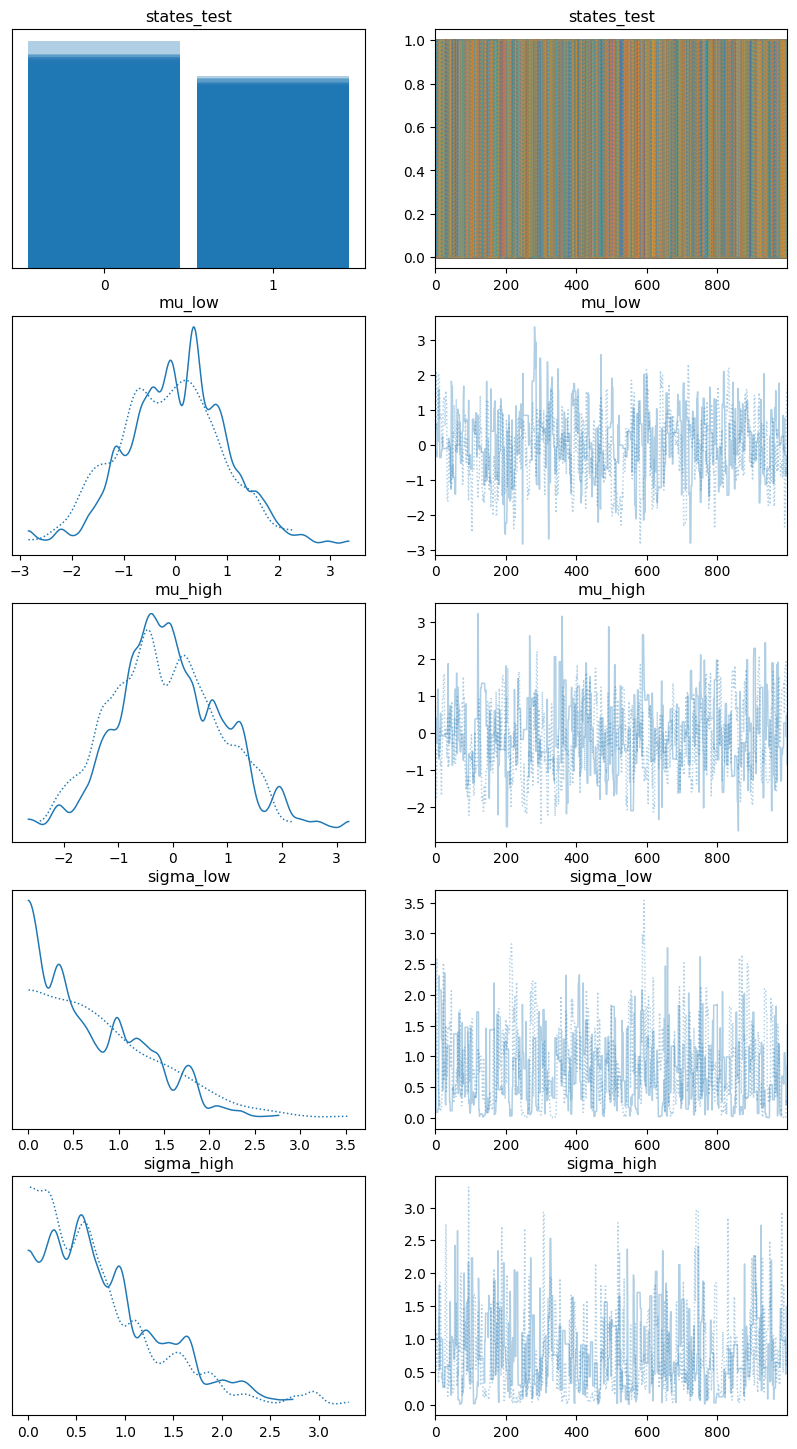

In [ ]:
np.random.seed(42)

# Inference on the testing set
with pm.Model() as model_inference:
    # Define states and observations for the testing set
    states_test = pm.Categorical('states_test', p=p_init_tensor, shape=len(X_test))

    obs_low_test_values = np.ma.masked_array(X_test['Volatility'].values, mask=(states_test != 0))
    obs_high_test_values = np.ma.masked_array(X_test['Volatility'].values, mask=(states_test != 1))

    # Define separate distributions for each state
    mu_low = pm.Normal('mu_low', mu=0, sigma=1)
    sigma_low = pm.HalfNormal('sigma_low', sigma=1)

    mu_high = pm.Normal('mu_high', mu=0, sigma=1)
    sigma_high = pm.HalfNormal('sigma_high', sigma=1)

    obs_low_test = pm.Normal('obs_low_test', mu=mu_low, sigma=sigma_low, observed=obs_low_test_values)
    obs_high_test = pm.Normal('obs_high_test', mu=mu_high, sigma=sigma_high, observed=obs_high_test_values)

   # Sample from the model for the testing set
    trace_test =  pm.sample(1000, tune=13000, step=pm.Metropolis(), cores=1)

# Plot the test set
pm.plot_trace(trace_test, figsize=(10, 18))

In [ ]:
pm.summary(trace_test).tail()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
states_test[251],0.468,0.499,0.000,1.000,0.024,0.017,422.0,422.0,1.00
mu_low,-0.048,0.963,-1.841,1.671,0.054,0.038,327.0,374.0,1.01
mu_high,-0.097,0.973,-1.889,1.739,0.061,0.043,256.0,419.0,1.01
sigma_low,0.808,0.614,0.001,1.832,0.037,0.026,240.0,253.0,1.01
sigma_high,0.767,0.592,0.002,1.851,0.032,0.023,255.0,414.0,1.01


In [ ]:
states_pred = np.median(trace_test.posterior.states_test.values, axis=(0, 1))

Accuracy: 73.41%
              precision    recall  f1-score   support

         0.0       0.77      0.93      0.84       190
         1.0       0.39      0.15      0.21        62

    accuracy                           0.73       252
   macro avg       0.58      0.54      0.53       252
weighted avg       0.68      0.73      0.69       252



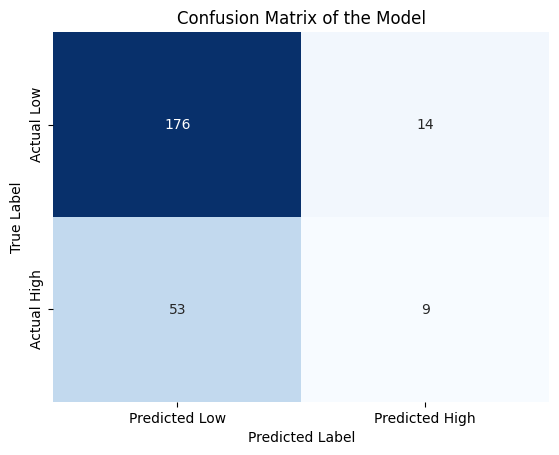

In [ ]:
accuracy = accuracy_score(y_test, states_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print a classification report for more detailed metrics
print(classification_report(y_test, states_pred))

# Visualize confusion matrix
cm = confusion_matrix(y_test, states_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix of the Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Convert the 'Timestamp' column to datetime
X_test['Timestamp'] = pd.to_datetime(X_test['Timestamp'], unit='s')
X_test.set_index('Timestamp', inplace=True)

# Print the X_test DataFrame
print(X_test)

              Adj Close      Volume    Return  Variance  Volatility  \
Timestamp                                                             
2022-02-22  4304.759766  5121900000 -0.010195  0.000196    0.013989   
2022-02-23  4225.500000  4797430000 -0.018584  0.000205    0.014320   
2022-02-24  4288.700195  6752130000  0.014846  0.000218    0.014781   
2022-02-25  4384.649902  5177060000  0.022126  0.000243    0.015581   
2022-02-28  4373.939941  6071370000 -0.002446  0.000213    0.014582   
...                 ...         ...       ...       ...         ...   
2023-02-15  4147.600098  4075980000  0.002769  0.000099    0.009966   
2023-02-16  4090.409912  4143660000 -0.013885  0.000108    0.010394   
2023-02-17  4079.090088  4045480000 -0.002771  0.000094    0.009704   
2023-02-21  3997.340088  4121590000 -0.020245  0.000110    0.010495   
2023-02-22  3991.050049  4079320000 -0.001575  0.000110    0.010499   

            Close_1_Value  Volume_1_Value  Close_2_Value  Volume_2_Value  \


In [ ]:
# Create a DataFrame to store variables
backtest_df = pd.DataFrame(index=X_test.index)
backtest_df['TrueState'] = y_test
backtest_df['PredictedState'] = states_pred
backtest_df['Volatility'] = X_test['Volatility']

In [ ]:
# Simulate trading decisions (sell if predicted state is High, buy if Low)
backtest_df['StrategyPosition'] = np.where(backtest_df['PredictedState'] == 1, -1, 1)

# Calculate strategy returns
backtest_df['StrategyReturns'] = backtest_df['StrategyPosition'] * backtest_df['Volatility']

# Cumulative returns
backtest_df['CumulativeReturns'] = (1 + backtest_df['StrategyReturns']).cumprod()

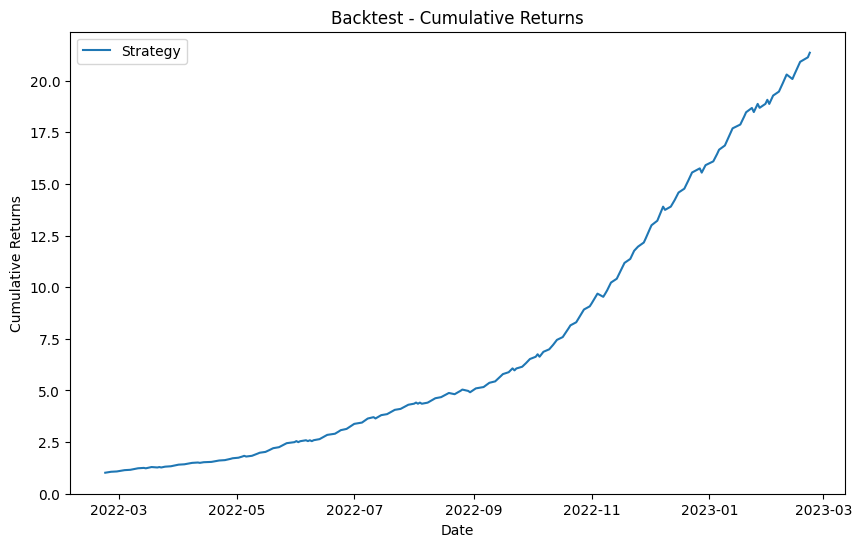

In [ ]:
# Plot cumulative returns with datetime x-axis
plt.figure(figsize=(10, 6))
plt.plot(backtest_df.index, backtest_df['CumulativeReturns'], label='Strategy')
plt.title('Backtest - Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

#4.0 Dynamic Trading Strategy

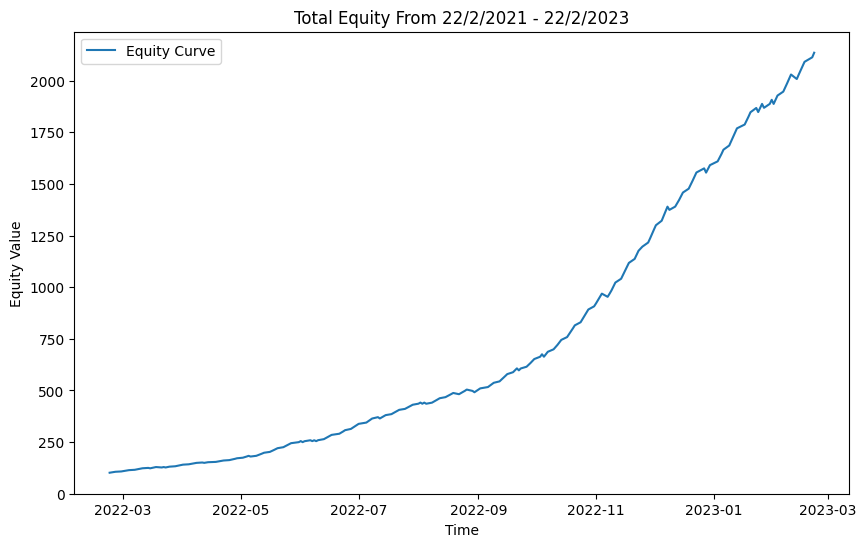

Sharpe Ratio: 1.3600
Annualized Sharpe Ratio: 21.5885
Total Equity Value at the End of Portfolio: 2135.49


In [ ]:
# Set the initial capital
initial_capital = 100

# Calculate the strategy equity curve
backtest_df['EquityCurve'] = initial_capital * backtest_df['CumulativeReturns']

# Calculate the daily returns of the strategy
backtest_df['DailyReturns'] = backtest_df['EquityCurve'].pct_change()

# Assuming a zero risk-free rate
risk_free_rate = 0.0

# Calculate the Sharpe ratio
sharpe_ratio = (backtest_df['DailyReturns'].mean() - risk_free_rate) / backtest_df['DailyReturns'].std()

# Annualize the Sharpe ratio
annualized_sharpe_ratio = sharpe_ratio * np.sqrt(252)

# Calculating the total value of the equity curve
total_equity_value = backtest_df['EquityCurve'].iloc[-1]

# Plotting the equity curve
plt.figure(figsize=(10, 6))
plt.plot(backtest_df['EquityCurve'], label='Equity Curve')
plt.title('Total Equity From 22/2/2021 - 22/2/2023')
plt.xlabel('Time')
plt.ylabel('Equity Value')
plt.legend()
plt.show()

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.4f}")
print(f"Total Equity Value at the End of Portfolio: {total_equity_value:.2f}")